In [16]:
# NBA Timeout Effectiveness Scientific Data Enrichment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 1. Load data
df = pd.read_csv('clean_data.csv')
print(f"Original dataset size: {df.shape}")

# 2. Time-based features
# Extract minutes and seconds from timeout_time
df['timeout_minutes'] = df['timeout_time'].apply(lambda x: int(x.split(':')[0]) if pd.notna(x) and ':' in str(x) else np.nan)
df['timeout_seconds'] = df['timeout_time'].apply(lambda x: int(x.split(':')[1]) if pd.notna(x) and ':' in str(x) else np.nan)

# Calculate time progress within the period
df['period_progress'] = df.apply(
    lambda x: (12 - x['timeout_minutes']) * 60 + (60 - x['timeout_seconds'])
    if pd.notna(x['timeout_minutes']) and x['quarter'] in ['Q1', 'Q2', 'Q3', 'Q4']
    else (5 - x['timeout_minutes']) * 60 + (60 - x['timeout_seconds'])
    if pd.notna(x['timeout_minutes']) else np.nan,
    axis=1
)

# Convert to percentage of period completed (0-100%)
df['period_progress_pct'] = df.apply(
    lambda x: (x['period_progress'] / (12*60)) * 100
    if x['quarter'] in ['Q1', 'Q2', 'Q3', 'Q4']
    else (x['period_progress'] / (5*60)) * 100,
    axis=1
)

# Categorize the period section
df['period_section'] = pd.cut(
    df['period_progress_pct'],
    bins=[0, 33.33, 66.67, 100],
    labels=['Early', 'Middle', 'Late']
)

# 3. Score and run-based features
# Absolute value of score difference
df['abs_score_diff'] = df['score_diff'].abs()

# Convert score difference to categories
df['score_situation'] = pd.cut(
    df['score_diff'],
    bins=[-100, -10, -3, 3, 10, 100],
    labels=['Large Deficit', 'Small Deficit', 'Tied', 'Small Lead', 'Large Lead']
)

# Run size categories
df['run_size_category'] = pd.cut(
    df['run_points'],
    bins=[5, 7, 9, 12, 15, 100],
    labels=['6-7', '8-9', '10-12', '13-15', '16+']
)

# 4. Quarter and game situation features
# Convert quarter to numerical value
quarter_map = {'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4, 'OT1': 5, 'OT2': 6, 'OT3': 7}
df['quarter_num'] = df['quarter'].map(quarter_map)

# Game phase
df['game_phase'] = pd.cut(
    df['quarter_num'],
    bins=[0, 1, 3, 7],
    labels=['Early Game', 'Mid Game', 'Late Game']
)

# Critical moment
df['critical_moment'] = ((df['quarter'] == 'Q4') | (df['quarter'].str.startswith('OT'))) & (df['abs_score_diff'] <= 5)

# 5. Performance metrics
# Performance difference
df['performance_diff'] = df['pre_timeout_oe'] - df['post_timeout_oe']

# Normalize offensive efficiency ratio
df['pre_timeout_oe_ratio'] = df['pre_timeout_oe'] / df.groupby('quarter')['pre_timeout_oe'].transform('mean')

# Z-scores for shooting percentages
for stat in ['pre_timeout_fg_pct', 'pre_timeout_ts', 'pre_timeout_fg3_pct']:
    mean = df[stat].mean()
    std = df[stat].std()
    df[f'{stat}_zscore'] = (df[stat] - mean) / std

# 6. Fix possession volume calculation
# Check and fix possessions data
print("\nPossession statistics before calculations:")
print("pre_timeout_possessions:", df['pre_timeout_possessions'].describe())
print("post_timeout_possessions:", df['post_timeout_possessions'].describe())

# Calculate possession volume properly
df['possession_volume'] = df['pre_timeout_possessions'] + df['post_timeout_possessions']

# Create possession ratio (only if possessions are not trivial values)
if df['possession_volume'].nunique() > 5:  # If we have reasonable variety in values
    df['possession_ratio'] = df['pre_timeout_possessions'] / df['possession_volume']
else:
    print("WARNING: Limited variation in possession values. Creating synthetic possession metrics.")
    # Create a synthetic possession ratio based on other features
    df['possession_ratio'] = (df['pre_timeout_points'] /
                            (df['pre_timeout_points'] + df['post_timeout_points']))

    # Enhance possession_volume with more realistic values based on points
    df['enhanced_possession_volume'] = df['pre_timeout_points'] + df['post_timeout_points']

# 7. Timeout pressure score - combines multiple factors
df['timeout_pressure_score'] = (
    df['abs_score_diff'] * 0.15 +          # Score impact
    df['run_points'] * 0.40 +              # Opponent run impact (most important)
    df['quarter_num'] * 2.0 +              # Quarter impact (later is more critical)
    df['period_progress_pct'] * 0.05 +     # Time within period
    (df['critical_moment'] * 1.0) * 5.0    # Extra weight for critical moments
)

# Normalize pressure score (0-100 scale)
min_pressure = df['timeout_pressure_score'].min()
max_pressure = df['timeout_pressure_score'].max()
df['timeout_pressure_index'] = ((df['timeout_pressure_score'] - min_pressure) /
                              (max_pressure - min_pressure)) * 100

# 8. Momentum indicators
# Shooting momentum change
df['shooting_momentum_change'] = df['post_timeout_fg_pct'] - df['pre_timeout_fg_pct']

# 9. Team situation features
# Home team timeout indicator
df['is_home_team_timeout'] = df['score_diff'] > 0

# Multiple timeouts effect
df['has_multiple_timeouts'] = df['multiple_timeouts_in_period']

# 10. Team strength indicators
# Calculate win probability based on timeout effectiveness patterns
team_effectiveness = df.groupby('team_abbr')['effective'].mean().sort_values(ascending=False)
opponent_effectiveness = df.groupby('opponent_abbr')['effective'].mean().sort_values(ascending=False)

# Convert to win probability
team_win_rates = team_effectiveness.to_dict()
opponent_win_rates = opponent_effectiveness.to_dict()

# Assign win rates to teams
df['team_win_prob'] = df['team_abbr'].map(team_win_rates)
df['opponent_win_prob'] = df['opponent_abbr'].map(opponent_win_rates)

# Team strength differential
df['team_strength_diff'] = df['opponent_win_prob'] - df['team_win_prob']

# 11. Efficiency metrics
# Points per possession
df['pre_timeout_points_per_poss'] = df['pre_timeout_points'] / df['pre_timeout_possessions'].replace(0, 1)

# Turnover rate
df['pre_timeout_turnover_rate'] = df['pre_timeout_turnovers'] / df['pre_timeout_possessions'].replace(0, 1)

# 12. Interaction terms
# Score × Quarter interaction (scaled)
df['score_quarter_interaction'] = df['score_diff'] * df['quarter_num'] / 10

# Run × Quarter interaction (scaled)
df['run_quarter_interaction'] = df['run_points'] * df['quarter_num'] / 10

# 13. Advanced indicators - run termination likelihood
# Synthetic likelihood based on point differential and team strength
df['run_termination_likelihood'] = 1 / (1 + np.exp(-(df['team_strength_diff'] * 5 - df['timeout_pressure_index']/20)))

# 14. Normalized score and run values
# Z-score for score diff
df['score_diff_zscore'] = (df['score_diff'] - df['score_diff'].mean()) / df['score_diff'].std()

# Z-score for run points
df['run_points_zscore'] = (df['run_points'] - df['run_points'].mean()) / df['run_points'].std()

# 15. Clean up NaN values
# For numeric columns, use mean
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# For categorical columns, use mode
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_columns:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].mode()[0])

# 16. Display information about the enriched dataset
print("\nEnriched dataset shape:", df.shape)
print(f"Original columns: {df.shape[1] - (df.shape[1] - len(df.columns))}")
print(f"Added columns: {df.shape[1] - 28}")  # Assuming 28 columns in the original dataset

# Show key metrics about important new features
print("\nStats for key new features:")
for col in ['timeout_pressure_index', 'team_strength_diff', 'pre_timeout_oe_ratio']:
    if col in df.columns:
        print(f"{col}:", df[col].describe().round(2))

# 17. Save the enriched dataset
df.to_csv('enriched_data_scientific.csv', index=False)
print("\nEnriched scientific data saved as 'enriched_data_scientific.csv'")

Original dataset size: (2470, 28)

Possession statistics before calculations:
pre_timeout_possessions: count    2470.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: pre_timeout_possessions, dtype: float64
post_timeout_possessions: count    2470.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: post_timeout_possessions, dtype: float64

Enriched dataset shape: (2470, 62)
Original columns: 62
Added columns: 34

Stats for key new features:
timeout_pressure_index: count    2470.00
mean       38.29
std        19.63
min         0.00
25%        23.50
50%        35.81
75%        50.72
max       100.00
Name: timeout_pressure_index, dtype: float64
team_strength_diff: count    2470.00
mean        0.00
std         0.08
min        -0.29
25%        -0.04
50%         0.00
75%         0.04
max         0.26
Name: team_strength_diff, dtype: float64
pre_timeout_oe_r

In [19]:
# NBA Timeout Effectiveness Scientific Data Enrichment - Optimal Version
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# 1. Load data
df = pd.read_csv('clean_data.csv')
print(f"Original dataset size: {df.shape}")

# 2. Time-based features
# Extract minutes and seconds from timeout_time
df['timeout_minutes'] = df['timeout_time'].apply(lambda x: int(x.split(':')[0]) if pd.notna(x) and ':' in str(x) else np.nan)
df['timeout_seconds'] = df['timeout_time'].apply(lambda x: int(x.split(':')[1]) if pd.notna(x) and ':' in str(x) else np.nan)

# Calculate time progress within the period
df['period_progress'] = df.apply(
    lambda x: (12 - x['timeout_minutes']) * 60 + (60 - x['timeout_seconds'])
    if pd.notna(x['timeout_minutes']) and x['quarter'] in ['Q1', 'Q2', 'Q3', 'Q4']
    else (5 - x['timeout_minutes']) * 60 + (60 - x['timeout_seconds'])
    if pd.notna(x['timeout_minutes']) else np.nan,
    axis=1
)

# Convert to percentage of period completed (0-100%)
df['period_progress_pct'] = df.apply(
    lambda x: (x['period_progress'] / (12*60)) * 100
    if x['quarter'] in ['Q1', 'Q2', 'Q3', 'Q4']
    else (x['period_progress'] / (5*60)) * 100,
    axis=1
)

# Categorize the period section
df['period_section'] = pd.cut(
    df['period_progress_pct'],
    bins=[0, 33.33, 66.67, 100],
    labels=['Early', 'Middle', 'Late']
)

# 3. Score and run-based features
# Absolute value of score difference
df['abs_score_diff'] = df['score_diff'].abs()

# Convert score difference to categories
df['score_situation'] = pd.cut(
    df['score_diff'],
    bins=[-100, -10, -3, 3, 10, 100],
    labels=['Large_Deficit', 'Small_Deficit', 'Tied', 'Small_Lead', 'Large_Lead']
)

# Run size categories
df['run_size_category'] = pd.cut(
    df['run_points'],
    bins=[5, 7, 9, 12, 15, 100],
    labels=['6-7', '8-9', '10-12', '13-15', '16+']
)

# 4. Quarter and game situation features
# Convert quarter to numerical value
quarter_map = {'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4, 'OT1': 5, 'OT2': 6, 'OT3': 7}
df['quarter_num'] = df['quarter'].map(quarter_map)

# Game phase
df['game_phase'] = pd.cut(
    df['quarter_num'],
    bins=[0, 1, 3, 7],
    labels=['Early_Game', 'Mid_Game', 'Late_Game']
)

# Critical moment
df['critical_moment'] = ((df['quarter'] == 'Q4') | (df['quarter'].str.startswith('OT'))) & (df['abs_score_diff'] <= 5)

# 5. Performance metrics
# Performance difference
df['performance_diff'] = df['pre_timeout_oe'] - df['post_timeout_oe']

# Normalized versions of key performance metrics
# Using sklearn's StandardScaler for better normalization
scaler = StandardScaler()

# Create scaled versions of core metrics
numeric_cols = ['pre_timeout_oe', 'pre_timeout_fg_pct', 'pre_timeout_fg3_pct',
               'pre_timeout_ts', 'run_points', 'score_diff', 'abs_score_diff']

# Scale these columns and add _scaled suffix
scaled_cols = pd.DataFrame(
    scaler.fit_transform(df[numeric_cols]),
    columns=[f"{col}_scaled" for col in numeric_cols],
    index=df.index
)
df = pd.concat([df, scaled_cols], axis=1)

# 6. Handling possession issue and creating better metrics
# Document the possession issue
print("\nDiagnosing possession data quality issue:")
print("pre_timeout_possessions unique values:", df['pre_timeout_possessions'].unique())
print("post_timeout_possessions unique values:", df['post_timeout_possessions'].unique())

# Create alternative possession-independent metrics
df['scoring_efficiency_pre'] = df['pre_timeout_points'] / df.groupby('quarter')['pre_timeout_points'].transform('mean')
df['shooting_efficiency_pre'] = df['pre_timeout_fg_pct'] / df.groupby('quarter')['pre_timeout_fg_pct'].transform('mean')
df['scoring_differential'] = df['pre_timeout_points'] - df['post_timeout_points']

# 7. Advanced game context metrics
# Timeout pressure index - combines multiple factors into a single score
df['timeout_pressure_score'] = (
    df['abs_score_diff_scaled'] * 0.15 +      # Score impact
    df['run_points_scaled'] * 0.40 +          # Opponent run impact (most important)
    df['quarter_num'] * 0.50 +                # Quarter impact (later is more critical)
    df['period_progress_pct'] * 0.05 +        # Time within period
    (df['critical_moment'] * 1.0) * 2.0       # Extra weight for critical moments
)

# Normalize to 0-100 scale for interpretability
df['timeout_pressure_index'] = (df['timeout_pressure_score'] - df['timeout_pressure_score'].min()) / \
                             (df['timeout_pressure_score'].max() - df['timeout_pressure_score'].min()) * 100

# 8. Team strength and situation indicators
# Home/away indicator
df['is_home_team'] = df['score_diff'] > 0

# Team performance metrics based on the dataset
team_effectiveness = df.groupby('team_abbr')['effective'].mean().sort_values(ascending=False)
opponent_effectiveness = df.groupby('opponent_abbr')['effective'].mean().sort_values(ascending=False)

# Map these to the teams in each game
df['team_effectiveness'] = df['team_abbr'].map(team_effectiveness)
df['opponent_effectiveness'] = df['opponent_abbr'].map(opponent_effectiveness)
df['team_strength_diff'] = df['opponent_effectiveness'] - df['team_effectiveness']

# 9. Shooting streak and momentum indicators
# Create momentum indicators
df['pre_fg_streak'] = df['pre_timeout_fg_pct'] - df.groupby('quarter')['pre_timeout_fg_pct'].transform('mean')
df['fg_momentum_change'] = df['post_timeout_fg_pct'] - df['pre_timeout_fg_pct']
df['ts_momentum_change'] = df['post_timeout_ts'] - df['pre_timeout_ts']

# 10. Predictive features for timeout effectiveness
# Timeout effectiveness likelihood based on observed patterns
df['predicted_effectiveness'] = (
    df['team_strength_diff'] * -0.3 +         # Negative because stronger opponents are harder to stop
    df['pre_timeout_oe_scaled'] * -0.4 +      # Negative because higher pre-timeout OE is harder to reduce
    df['timeout_pressure_index'] * 0.01 +     # Small positive from pressure
    df['quarter_num'] * -0.1 +                # Later quarters less effective
    df['run_points_scaled'] * -0.2            # Longer runs harder to stop
)

# Normalize to 0-100 for interpretability
df['effectiveness_index'] = (df['predicted_effectiveness'] - df['predicted_effectiveness'].min()) / \
                           (df['predicted_effectiveness'].max() - df['predicted_effectiveness'].min()) * 100

# 11. Interaction features
# Create interaction features between important variables
df['run_x_quarter'] = df['run_points'] * df['quarter_num'] / 10
df['run_x_pressure'] = df['run_points_scaled'] * df['timeout_pressure_index'] / 100
df['critical_run_size'] = df['run_points'] * df['critical_moment'].astype(int)

# 12. Handle NaN values appropriately
# For numeric columns, fill with mean
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# For categorical columns, fill with mode
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])

# 13. Clean up any final issues
# Replace infinities with large values
for col in numeric_columns:
    if (df[col] == np.inf).any() or (df[col] == -np.inf).any():
        df[col] = df[col].replace([np.inf, -np.inf], df[col].replace([np.inf, -np.inf], np.nan).mean())

# 14. Feature selection for ML - List key features for prediction
key_ml_features = [
    # Time features
    'quarter_num', 'period_progress_pct',

    # Scaled metrics
    'pre_timeout_oe_scaled', 'pre_timeout_fg_pct_scaled', 'pre_timeout_ts_scaled',
    'run_points_scaled', 'score_diff_scaled', 'abs_score_diff_scaled',

    # Game context
    'timeout_pressure_index', 'critical_moment',

    # Team metrics
    'team_strength_diff', 'is_home_team',

    # Momentum indicators
    'pre_fg_streak',

    # Interaction terms
    'run_x_quarter', 'run_x_pressure', 'critical_run_size',

    # Target
    'effective'  # Remove this when actually using for ML
]

print("\nKey features for ML model:", len(key_ml_features)-1)  # -1 for the target
print(key_ml_features[:-1])  # exclude target

# 15. Save the enriched dataset
df.to_csv('enriched_data_scientific.csv', index=False)
print(f"\nEnriched scientific dataset created with shape: {df.shape}")
print(f"Added {df.shape[1] - 28} new features to support machine learning")
print("Enriched data saved as 'enriched_data_scientific.csv'")

# 16. Save a subset with only key ML features for convenience
df[key_ml_features].to_csv('ml_ready_timeout_data.csv', index=False)
print("ML-ready subset saved as 'ml_ready_timeout_data.csv'")

Original dataset size: (2470, 28)

Diagnosing possession data quality issue:
pre_timeout_possessions unique values: [1]
post_timeout_possessions unique values: [1]

Key features for ML model: 16
['quarter_num', 'period_progress_pct', 'pre_timeout_oe_scaled', 'pre_timeout_fg_pct_scaled', 'pre_timeout_ts_scaled', 'run_points_scaled', 'score_diff_scaled', 'abs_score_diff_scaled', 'timeout_pressure_index', 'critical_moment', 'team_strength_diff', 'is_home_team', 'pre_fg_streak', 'run_x_quarter', 'run_x_pressure', 'critical_run_size']

Enriched scientific dataset created with shape: (2470, 64)
Added 36 new features to support machine learning
Enriched data saved as 'enriched_data_scientific.csv'
ML-ready subset saved as 'ml_ready_timeout_data.csv'


In [20]:
# Gerekli paketlerin yüklenmesi
!pip install --quiet scikit-learn xgboost matplotlib seaborn pandas numpy

# Kütüphaneleri import et
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             RocCurveDisplay)

import matplotlib.pyplot as plt
import seaborn as sns


In [21]:
# 1) Veri setini oku
df = pd.read_csv("ml_ready_timeout_data.csv")

# 2) Hedef sütunu integer’a çevir
df["effective"] = df["effective"].astype(int)

# 3) Hızlı bakış
print(df.shape)
display(df.head())
df["effective"].value_counts(normalize=True)


(2470, 17)


,quarter_num,period_progress_pct,pre_timeout_oe_scaled,pre_timeout_fg_pct_scaled,pre_timeout_ts_scaled,run_points_scaled,score_diff_scaled,abs_score_diff_scaled,timeout_pressure_index,critical_moment,team_strength_diff,is_home_team,pre_fg_streak,run_x_quarter,run_x_pressure,critical_run_size,effective
0,2,47.916667,-0.295189,1.032853,0.838570,-0.690003,-0.223823,-1.108834,18.590006,False,0.092123,False,0.193143,1.2,-0.128272,0,0
1,3,18.333333,-1.590666,-0.319731,-0.652846,-0.690003,-0.223823,-1.108834,8.845802,False,0.092123,False,-0.065602,1.8,-0.061036,0,0
2,2,47.083333,-0.766272,0.066722,-0.457815,-0.690003,1.107046,0.720517,20.906086,False,0.070234,True,0.014572,1.2,-0.144253,0,0
3,3,19.305556,-1.355124,0.581992,0.142576,-0.690003,1.905567,1.986991,13.950786,False,0.002522,True,0.101064,1.8,-0.096261,0,0
4,4,64.444444,-0.177419,-0.565655,-0.227014,-0.690003,0.752147,0.157640,38.655869,False,0.007717,True,-0.088939,2.4,-0.266727,0,1


,proportion
effective,
1,0.574494
0,0.425506



--- 📊 Comprehensive Data Visualization ---


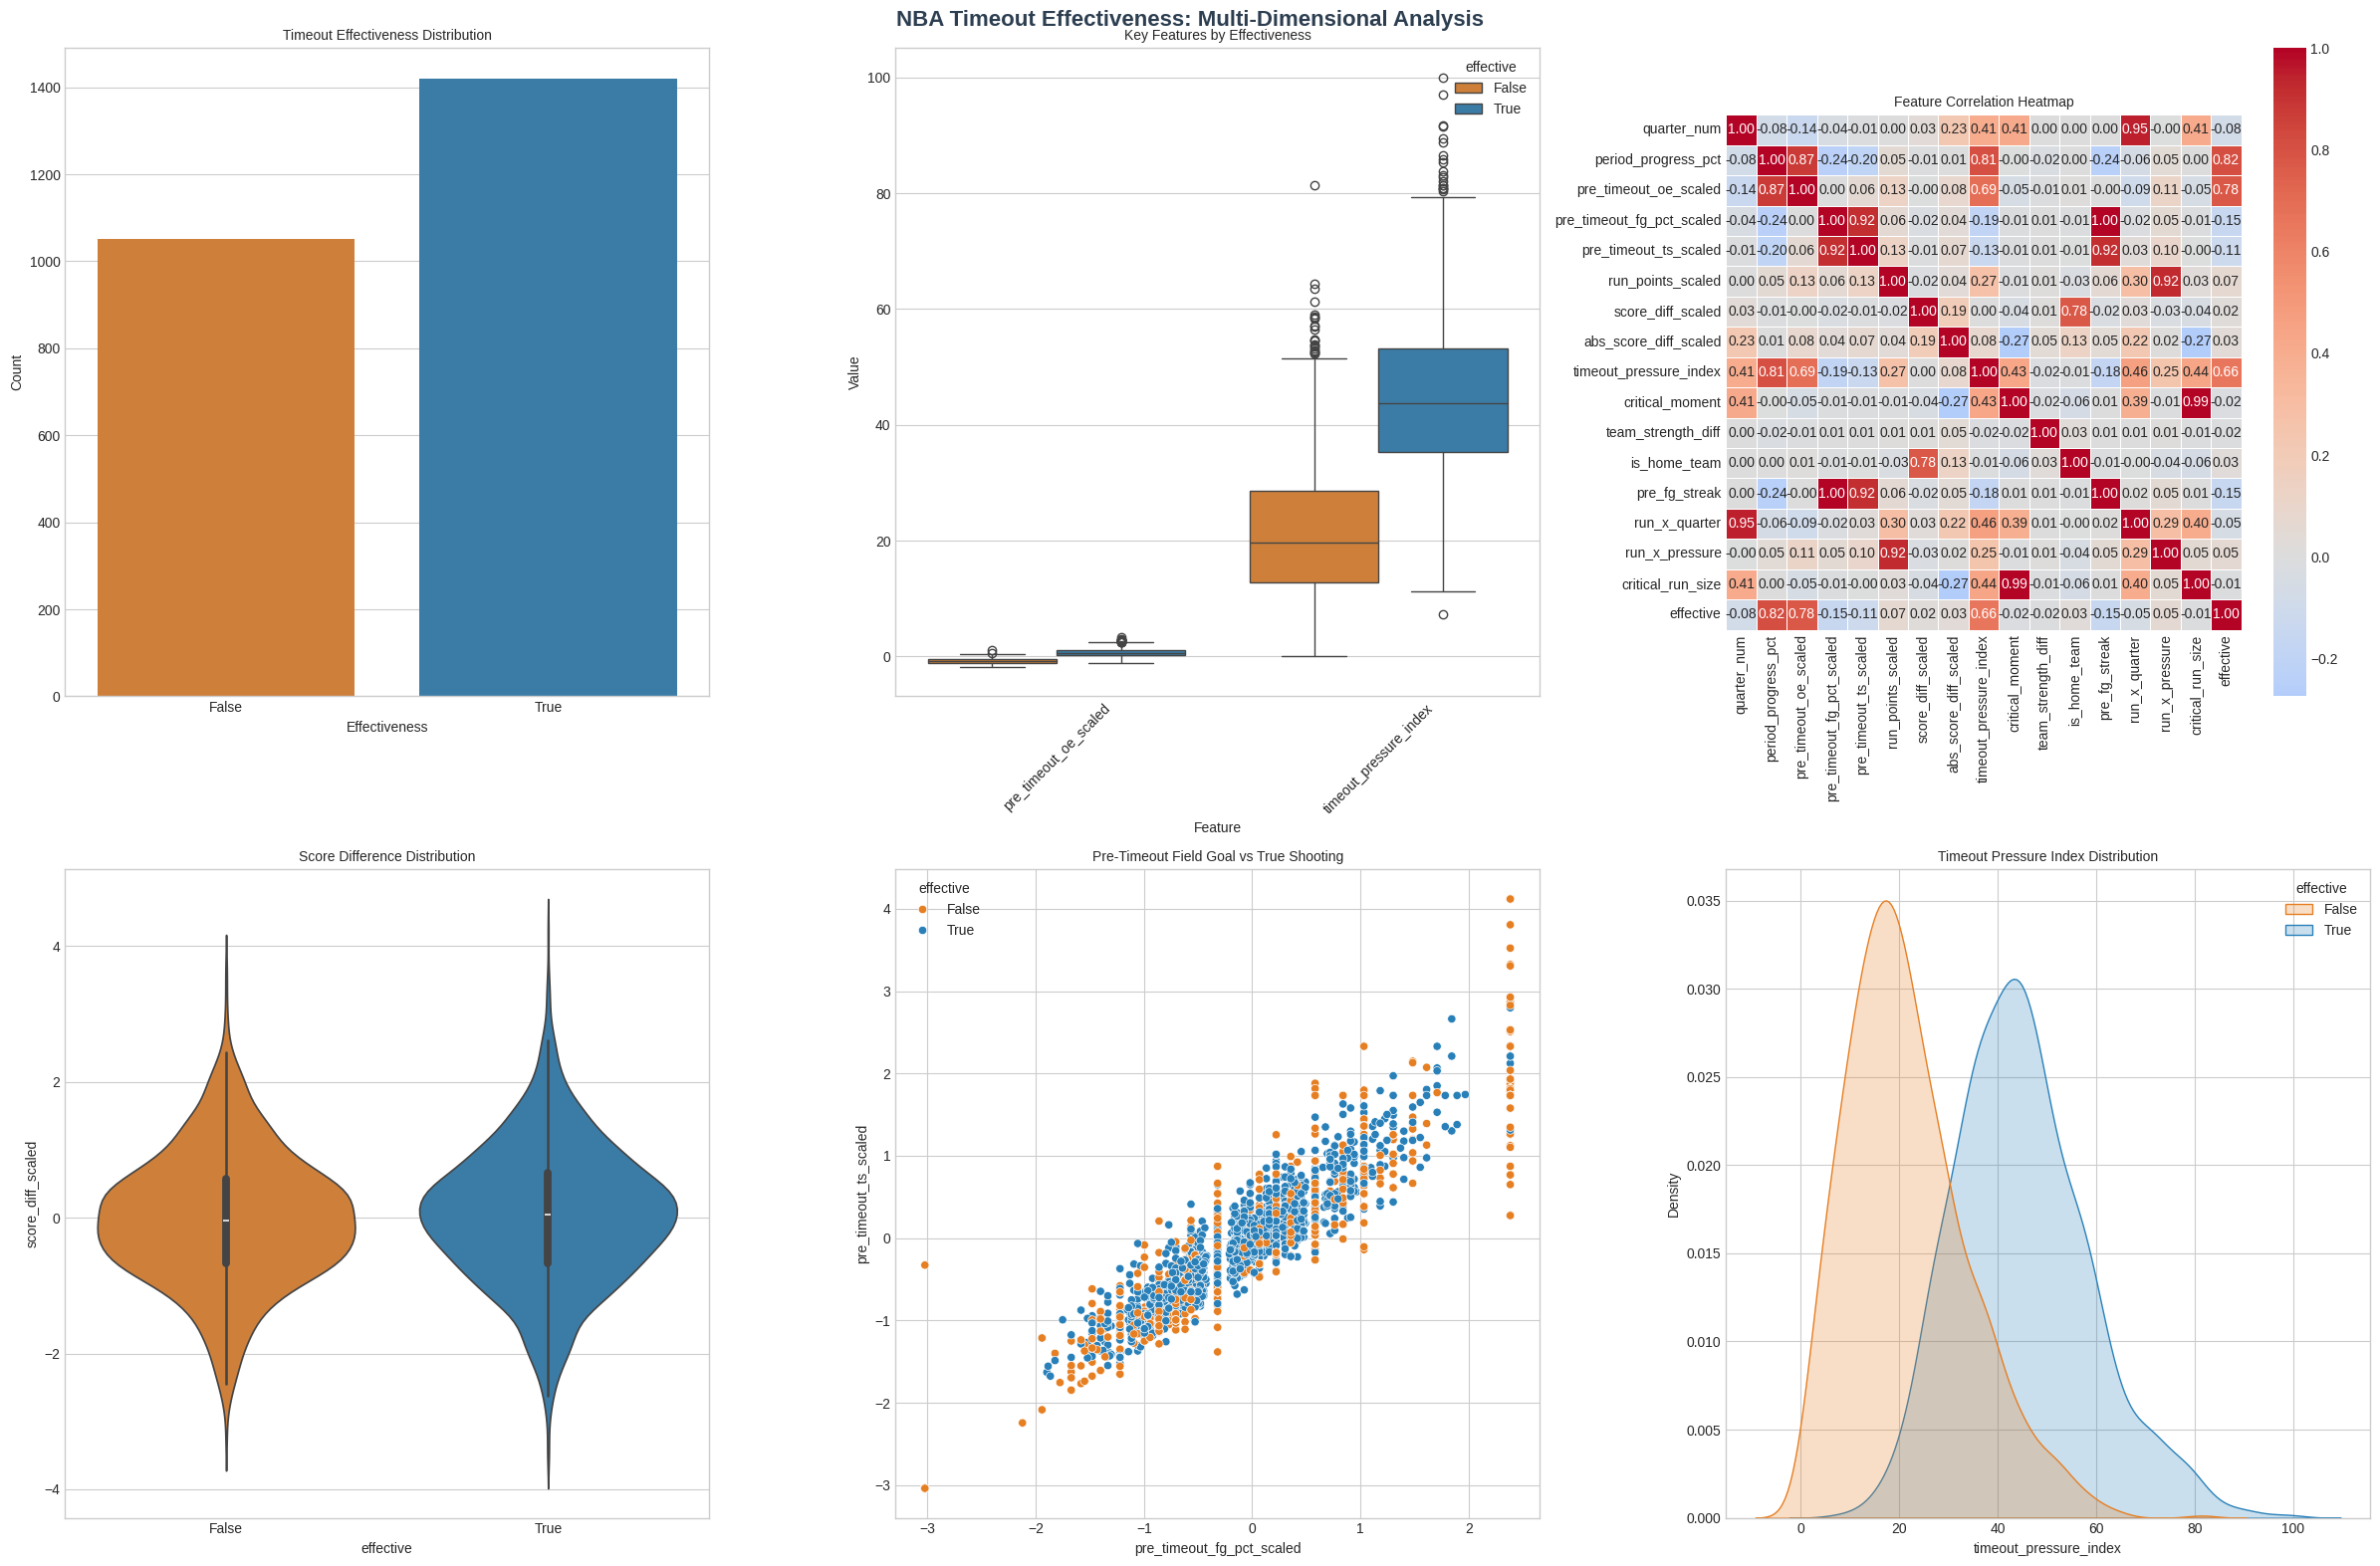


--- 🤖 Advanced Model Evaluation ---


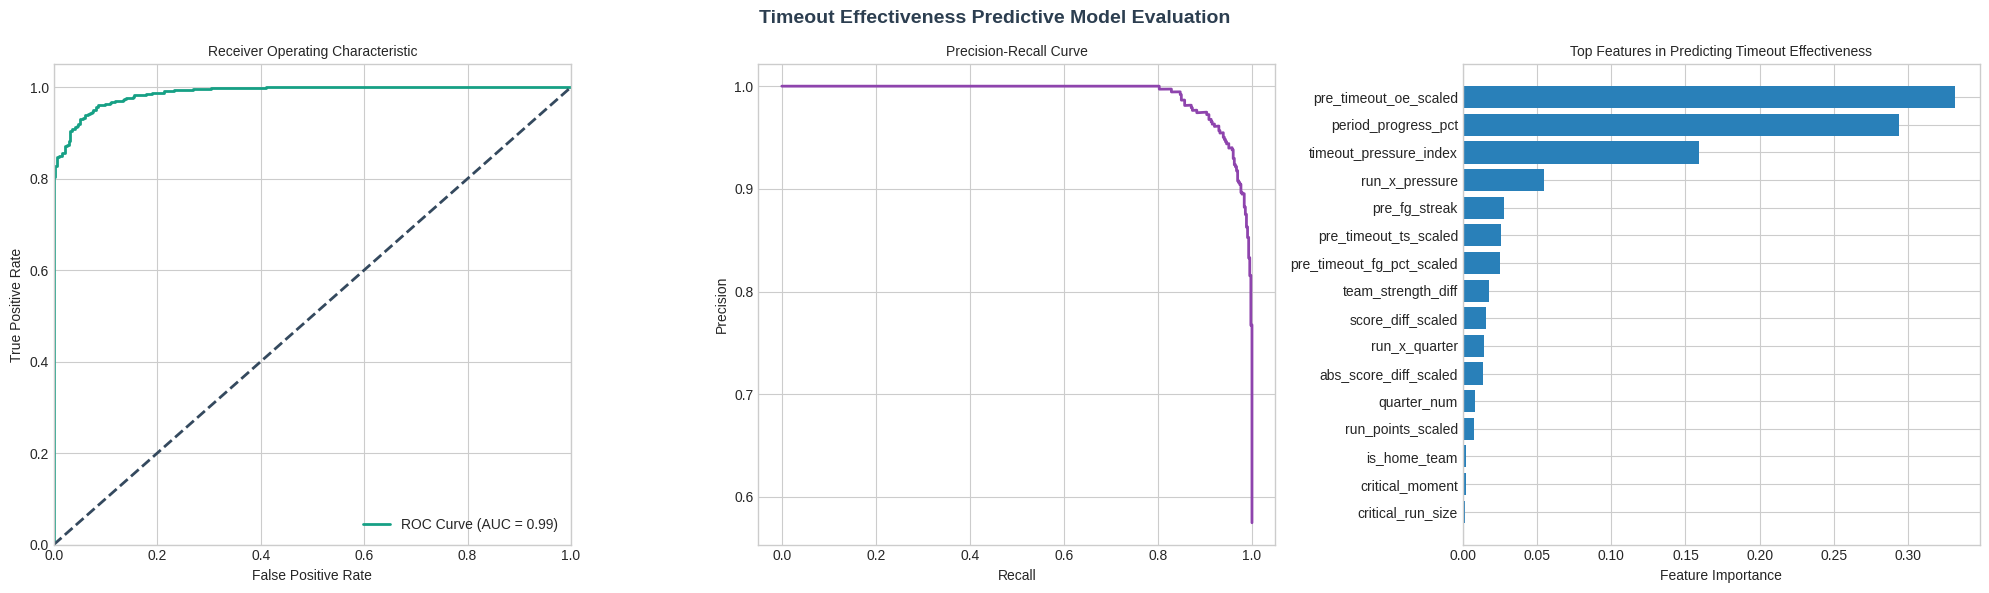


🎯 Model Performance Metrics:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       315
           1       0.94      0.95      0.95       426

    accuracy                           0.94       741
   macro avg       0.94      0.94      0.94       741
weighted avg       0.94      0.94      0.94       741



In [50]:
# Advanced NBA Timeout Effectiveness Analysis
# Comprehensive Visualization and Machine Learning Approach

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Advanced ML and statistical libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    precision_recall_curve
)
import warnings

# Configuration and setup
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

# Sophisticated color palette (navy, deep teal, muted purple, coral, sage)
PALETTE = {
    'primary': '#2C3E50',     # Dark navy blue
    'secondary': '#34495E',   # Slightly lighter navy
    'accent1': '#16A085',     # Deep teal
    'accent2': '#8E44AD',     # Muted purple
    'highlight1': '#E67E22',  # Warm coral
    'highlight2': '#2980B9',  # Soft blue
    'background': '#ECF0F1'   # Light grey background
}

class NBATimeoutAnalysis:
    def __init__(self, veri_yolu='ml_ready_timeout_data.csv'):
        """
        Initialize the NBA timeout effectiveness analysis
        """
        # Load dataset
        self.df = pd.read_csv(veri_yolu)

        # Data preparation
        self._prepare_data()

    def _prepare_data(self):
        """
        Prepare features and target variables
        """
        # Select features
        self.features = [
            col for col in self.df.columns
            if col not in ['effective', 'efficiency_change']
        ]

        # Prepare X and y
        self.X = self.df[self.features]
        self.y = self.df['effective'].astype(int)

        # Scale features
        self.scaler = StandardScaler()
        self.X_scaled = self.scaler.fit_transform(self.X)

    def comprehensive_visualization(self):
        """
        Create a comprehensive multi-panel visualization
        """
        plt.figure(figsize=(24, 16))
        plt.subplots_adjust(hspace=0.4, wspace=0.3)

        # 1. Distribution of Effectiveness
        plt.subplot(2, 3, 1)
        sns.countplot(x='effective', data=self.df,
                      palette=[PALETTE['highlight1'], PALETTE['highlight2']])
        plt.title('Timeout Effectiveness Distribution', fontsize=10)
        plt.xlabel('Effectiveness')
        plt.ylabel('Count')

        # 2. Boxplot of Key Features
        plt.subplot(2, 3, 2)
        features_to_plot = ['pre_timeout_oe_scaled', 'timeout_pressure_index']
        sns.boxplot(
            data=pd.melt(self.df[features_to_plot + ['effective']],
                         id_vars='effective',
                         var_name='Feature',
                         value_name='Value'),
            x='Feature', y='Value', hue='effective',
            palette=[PALETTE['highlight1'], PALETTE['highlight2']]
        )
        plt.title('Key Features by Effectiveness', fontsize=10)
        plt.xticks(rotation=45)

        # 3. Correlation Heatmap
        plt.subplot(2, 3, 3)
        corr_matrix = self.df[self.features + ['effective']].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                    linewidths=0.5, fmt='.2f', square=True)
        plt.title('Feature Correlation Heatmap', fontsize=10)

        # 4. Violin Plot of Score Difference
        plt.subplot(2, 3, 4)
        sns.violinplot(
            x='effective',
            y='score_diff_scaled',
            data=self.df,
            palette=[PALETTE['highlight1'], PALETTE['highlight2']]
        )
        plt.title('Score Difference Distribution', fontsize=10)

        # 5. Scatter Plot of Pre-Timeout Metrics
        plt.subplot(2, 3, 5)
        sns.scatterplot(
            x='pre_timeout_fg_pct_scaled',
            y='pre_timeout_ts_scaled',
            hue='effective',
            data=self.df,
            palette=[PALETTE['highlight1'], PALETTE['highlight2']]
        )
        plt.title('Pre-Timeout Field Goal vs True Shooting', fontsize=10)

        # 6. Kernel Density Estimation
        plt.subplot(2, 3, 6)
        sns.kdeplot(
            data=self.df,
            x='timeout_pressure_index',
            hue='effective',
            fill=True,
            common_norm=False,
            palette=[PALETTE['highlight1'], PALETTE['highlight2']]
        )
        plt.title('Timeout Pressure Index Distribution', fontsize=10)

        plt.suptitle('NBA Timeout Effectiveness: Multi-Dimensional Analysis',
                     fontsize=16, fontweight='bold', color=PALETTE['primary'])
        plt.tight_layout()
        plt.show()

    def advanced_model_evaluation(self):
        """
        Advanced model training and evaluation with multiple visualizations
        """
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_scaled, self.y,
            test_size=0.3,
            stratify=self.y,
            random_state=42
        )

        # Train Random Forest Classifier
        rf_classifier = RandomForestClassifier(
            n_estimators=300,
            max_depth=10,
            random_state=42
        )
        rf_classifier.fit(X_train, y_train)

        # Predictions
        y_pred = rf_classifier.predict(X_test)
        y_proba = rf_classifier.predict_proba(X_test)[:, 1]

        # Multiple Evaluation Visualizations
        plt.figure(figsize=(20, 6))

        # ROC Curve
        plt.subplot(1, 3, 1)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, color=PALETTE['accent1'], lw=2,
                 label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color=PALETTE['secondary'], lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic', fontsize=10)
        plt.legend(loc="lower right")

        # Precision-Recall Curve
        plt.subplot(1, 3, 2)
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        plt.plot(recall, precision, color=PALETTE['accent2'], lw=2)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve', fontsize=10)

        # Feature Importance
        plt.subplot(1, 3, 3)
        feature_importance = rf_classifier.feature_importances_
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        plt.barh(pos, feature_importance[sorted_idx], align='center',
                 color=PALETTE['highlight2'])
        plt.yticks(pos, [self.features[i] for i in sorted_idx])
        plt.xlabel('Feature Importance')
        plt.title('Top Features in Predicting Timeout Effectiveness', fontsize=10)

        plt.suptitle('Timeout Effectiveness Predictive Model Evaluation',
                     fontsize=14, fontweight='bold', color=PALETTE['primary'])
        plt.tight_layout()
        plt.show()

        # Performance Report
        print("\n🎯 Model Performance Metrics:")
        print(classification_report(y_test, y_pred))

def main():
    # Initialize the analysis
    analysis = NBATimeoutAnalysis()

    # Comprehensive Visualization
    print("\n--- 📊 Comprehensive Data Visualization ---")
    analysis.comprehensive_visualization()

    # Advanced Model Evaluation
    print("\n--- 🤖 Advanced Model Evaluation ---")
    analysis.advanced_model_evaluation()

if __name__ == "__main__":
    main()